# Collaborative Filtering Based Model
In this notebook, we develop a collaborative recommendation system to predict user preferences based on historical order data. We will implement k-Nearest Neighbors (kNN), Singular Value Decomposition (SVD), and Neural Collaborative Filtering (NCF) for collaborative filtering to identify patterns in user behavior. These approaches will help us build a robust, scalable recommendation engine. To evaluate the models, we will use RMSE, MSE, and MAE as our metrics, ensuring we can objectively assess their accuracy and select the best-performing model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
user_product_data = pd.read_csv('data/user-product-data.csv')
user_item_matrix = pd.read_csv('data/user-item-matrix.csv', index_col=0)

In [3]:
product_ids = user_item_matrix.columns.astype(int)
product_to_index = {product_id: idx for idx, product_id in enumerate(product_ids)}
index_to_product = {idx: product_id for idx, product_id in enumerate(product_ids)}
user_product_data['Updated Product ID'] = user_product_data['Product ID'].map(product_to_index)
user_item_matrix.columns = [product_to_index[col] for col in user_item_matrix.columns.astype(int)]

user_product_data['Product Bought'] = user_product_data['Product Bought'].astype(np.float32)

product_scores = user_item_matrix.sum(axis=0)
top_products = product_scores.sort_values(ascending=False)[:10].index.tolist()

In [4]:
train, test = train_test_split(user_product_data, test_size=0.15, random_state=42)

train_data = train.pivot_table(index='User ID', columns='Updated Product ID', values='Product Bought', fill_value=0)
train_data = test.pivot_table(index='User ID', columns='Updated Product ID', values='Product Bought', fill_value=0)

train_data = train_data.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns, fill_value=0)
test_data = train_data.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns, fill_value=0)

### k-Nearest Neighbors (kNN)

In [5]:
def evaluate_knn(n_neighbors, train_data, test_data):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(train_data)

    distances, neighbor = knn.kneighbors(test_data)
    neighbor_matrix = user_item_matrix.values[neighbor]
    prediction = np.mean(neighbor_matrix, axis=1)
    
    prediction = prediction.flatten()
    prediction = (prediction >= 0.5).astype(int)
    actual = test_data.values.flatten()

    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    cm = confusion_matrix(actual, prediction)

    return (precision, recall, f1, cm, knn)

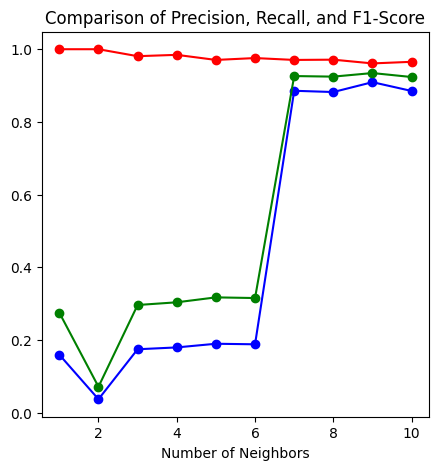

In [6]:
neighbor_range = range(1, 11)
results = []
for n in neighbor_range:
    precision, recall, f1, cm, knn = evaluate_knn(n, train_data, test_data)
    results.append([n, precision, recall, f1])
    
results = pd.DataFrame(results, columns=['n_neighbors', 'Precision', 'Recall', 'F1'])

plt.figure(figsize=(5, 5))
plt.plot(results['n_neighbors'], results['Precision'], marker='o', color='blue', label='Precision')
plt.plot(results['n_neighbors'], results['Recall'], marker='o', color='red', label='Recall')
plt.plot(results['n_neighbors'], results['F1'], marker='o', color='green', label='F1')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.xlabel('Number of Neighbors')
plt.show()

**We have the highest Precision, Recall, and F1-Score at n_neighbors = 7, and the performance remains stable afterward, so we will proceed with this value.**

KNN Evaluation Metrics:
Precision: 0.8857
Recall: 0.9705
F1-Score: 0.9262


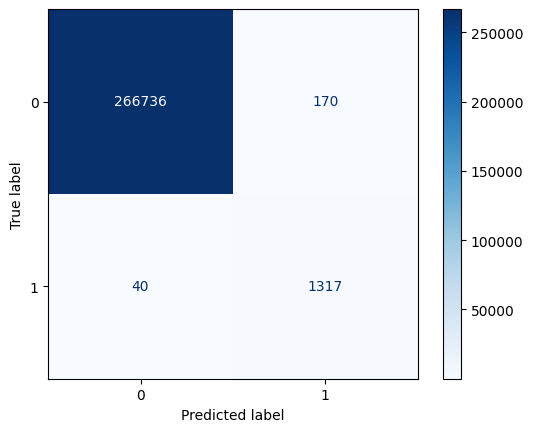

In [7]:
knn_precision, knn_recall, knn_f1, knn_cm, knn_model = evaluate_knn(7, train_data, test_data)

print("KNN Evaluation Metrics:")
print(f"Precision: {knn_precision:.4f}")
print(f"Recall: {knn_recall:.4f}")
print(f"F1-Score: {knn_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot(cmap='Blues')
plt.show()

In [8]:
def knn_recommend(user_id, user_item_matrix, knn_model, n_recommendations=3):
    if user_id not in user_item_matrix.index:
        raise ValueError(f"User {user_id} not found in the user-item matrix.")
        
    user_purchases = user_item_matrix.loc[user_id]
    user_matrix = user_purchases.values.reshape(1, -1)
    distances, neighbors = knn_model.kneighbors(user_matrix, n_neighbors=n_recommendations)
    
    neighbor_matrix = user_item_matrix.iloc[neighbors.flatten()]
    product_scores = neighbor_matrix.sum(axis=0)
    # Remove already purchased products
    product_scores = product_scores * (user_purchases.values == 0)
    # Remove products with score = 0 (not purchased by any of the neighbors)
    product_scores = product_scores[product_scores > 0]

    recommended_indices = product_scores.sort_values(ascending=False)[:n_recommendations].index.tolist()

    # Add already purchased products
    if len(recommended_indices) < n_recommendations:
        purchased_products = user_purchases[user_purchases > 0].index.tolist()
        remaining_count = n_recommendations - len(recommended_indices)
        purchased_products = [p for p in purchased_products if p not in recommended_indices]
        recommended_indices.extend(purchased_products[:remaining_count])
    # Add top products (most purchased products from all users)
    if len(recommended_indices) < n_recommendations:
        remaining_count = n_recommendations - len(recommended_indices)
        top_products_filtered = [p for p in top_products if p not in recommended_indices]
        recommended_indices.extend(top_products_filtered[:remaining_count])
    
    recommended_products = [index_to_product[idx] for idx in recommended_indices]
    return recommended_products

In [9]:
#Check for a random user
user_id = user_item_matrix.sample(n=1).index[0]
recommended_products = knn_recommend(user_id, user_item_matrix, knn_model, 10)

print(f"Recommended products for {user_id}: {recommended_products}")

Recommended products for 2093: [1958, 610, 20436, 499, 3691, 1707, 615, 2381, 2386, 1981]


### Singular Value Decomposition (SVD) - TruncatedSVD

In [10]:
# train, test = train_test_split(user_item_matrix, test_size=0.15, random_state=10)

In [11]:
def evaluate_svd(n_components, train_data, test_data):
    svd = TruncatedSVD(n_components=n_components)
    svd.fit(train_data)
    
    test_svd = svd.transform(test_data)
    prediction = np.dot(test_svd, svd.components_)
    
    prediction = (prediction.flatten() >= 0.5).astype(int)
    actual = test_data.values.flatten()
    
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    cm = confusion_matrix(actual, prediction)

    return precision, recall, f1, cm, svd

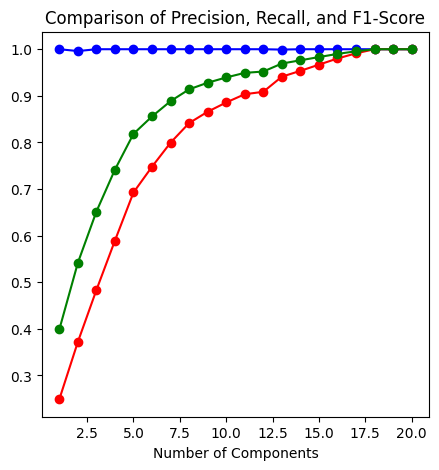

In [12]:
components_range = range(1, 21)
results = []
for component in components_range:
    precision, recall, f1, cm, svd = evaluate_svd(component, train_data, test_data)
    results.append([component, precision, recall, f1])
    
results = pd.DataFrame(results, columns=['n_components', 'Precision', 'Recall', 'F1'])

plt.figure(figsize=(5, 5))
plt.plot(results['n_components'], results['Precision'], marker='o', color='blue', label='Precision')
plt.plot(results['n_components'], results['Recall'], marker='o', color='red', label='Recall')
plt.plot(results['n_components'], results['F1'], marker='o', color='green', label='F1')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.xlabel('Number of Components')
plt.show()

**After observing a perfect F1-Score, Precision, and Recall at n_components = 18, we recognized the model was overfitting. To avoid this, we selected n_components = 15 to balance performance and complexity, ensuring better generalization without overfitting.**


SVD Evaluation Metrics:
Precision: 1.0000
Recall: 0.9668
F1-Score: 0.9831


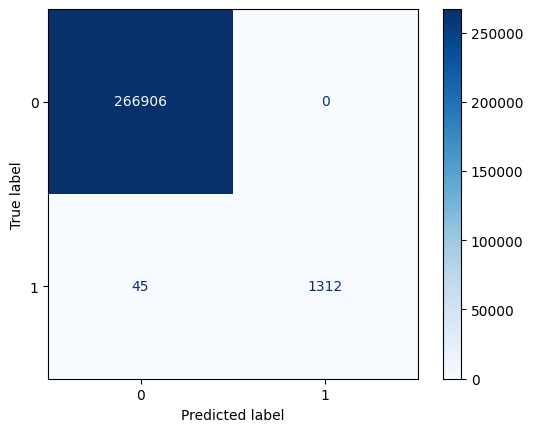

In [13]:
svd_precision, svd_recall, svd_f1, svd_cm, svd_model = evaluate_svd(15, train_data, test_data)

print("SVD Evaluation Metrics:")
print(f"Precision: {svd_precision:.4f}")
print(f"Recall: {svd_recall:.4f}")
print(f"F1-Score: {svd_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=svd_cm)
disp.plot(cmap='Blues')
plt.show()

In [14]:
def svd_recommend(user_id, user_item_matrix, svd_model, n_recommendations=3):
    if user_id not in user_item_matrix.index:
        raise ValueError(f"User {user_id} not found in the user-item matrix.")
        
    user_purchases = user_item_matrix.loc[user_id]
    user_matrix = user_purchases.values.reshape(1, -1)
    user_svd = svd_model.transform(user_matrix)
    user_recommendations = np.dot(user_svd, svd_model.components_)
    
    product_scores = user_recommendations.flatten()
    product_scores = pd.Series(product_scores)
    # Remove already purchased products
    product_scores = product_scores * (user_purchases.values == 0)
    # Remove products with score = 0 (not purchased by any of the neighbors)
    product_scores = product_scores[product_scores > 0]
    
    recommended_indices = product_scores.sort_values(ascending=False)[:n_recommendations].index.tolist()

    # Add already purchased products
    if len(recommended_indices) < n_recommendations:
        purchased_products = user_purchases[user_purchases > 0].index.tolist()
        remaining_count = n_recommendations - len(recommended_indices)
        purchased_products = [p for p in purchased_products if p not in recommended_indices]
        recommended_indices.extend(purchased_products[:remaining_count])
    # Add top products (most purchased products from all users)
    if len(recommended_indices) < n_recommendations:
        remaining_count = n_recommendations - len(recommended_indices)
        top_products_filtered = [p for p in top_products if p not in recommended_indices]
        recommended_indices.extend(top_products_filtered[:remaining_count])
    
    recommended_products = [index_to_product[idx] for idx in recommended_indices]
    return recommended_products

In [15]:
#Check for a random user
user_id = user_item_matrix.sample(n=1).index[0]
user_purchases = user_item_matrix.loc[user_id]
recommended_products = svd_recommend(user_id, user_item_matrix, svd_model, 10)

print(f"Recommended products for {user_id}: {recommended_products}")

Recommended products for 1907: [15535, 4211, 2387, 8041, 16104, 8053, 2386, 610, 20436, 4010]


### Neural Collaborative Filtering (NCF)

In [16]:
num_features_train = train.shape[0]
num_features_test = test.shape[0]

In [17]:
embedding_dim = 32
num_users = user_product_data['User ID'].max()
num_products = user_product_data['Updated Product ID'].nunique()

l2_reg = 0.001 
kernel_regularizer=tf.keras.regularizers.l2(l2_reg)

# User embeddings
input_user = tf.keras.layers.Input(1)
user_embedding = tf.keras.layers.Embedding(num_users+1, embedding_dim)(input_user)
user_vec = tf.keras.layers.Flatten()(user_embedding)

# Product embeddings
input_product = tf.keras.layers.Input(1)
product_embedding = tf.keras.layers.Embedding(num_products+1, embedding_dim)(input_product)
product_vec = tf.keras.layers.Flatten()(product_embedding)

dot_layer = tf.keras.layers.Dot(axes=1)([user_vec, product_vec])
# dense_layer = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=kernel_regularizer)(dot_layer)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dot_layer)

ncf_model = tf.keras.Model([input_user, input_product], output)

ncf_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 32)                216064    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 32)                1344      ['input_2[0][0]']             
                                                                                             

In [18]:
ncf_metrics=['accuracy','Precision', 'Recall', 'F1Score']
cost_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

neg, pos = np.bincount(user_product_data['Product Bought'])
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

ncf_model.compile(optimizer=opt, loss=cost_fn, metrics=ncf_metrics)
history = ncf_model.fit([train['User ID'],train['Updated Product ID']], train['Product Bought'].astype(np.float32),
                        validation_data=([test['User ID'],test['Updated Product ID']], test['Product Bought'].astype(np.float32)),
                        shuffle=True, class_weight=class_weights, epochs=20, batch_size=64)

Epoch 1/20


3563/3563 [==============================] - 26s 7ms/step - loss: 0.3902 - accuracy: 0.7645 - precision: 0.1102 - recall: 0.8633 - f1_score: 0.0641 - val_loss: 0.3890 - val_accuracy: 0.7866 - val_precision: 0.1257 - val_recall: 0.8946 - val_f1_score: 0.0652
Epoch 2/20
3563/3563 [==============================] - 26s 7ms/step - loss: 0.1166 - accuracy: 0.9473 - precision: 0.3828 - recall: 0.9627 - f1_score: 0.0996 - val_loss: 0.2901 - val_accuracy: 0.8859 - val_precision: 0.1757 - val_recall: 0.6455 - val_f1_score: 0.0961
Epoch 3/20
3563/3563 [==============================] - 32s 9ms/step - loss: 0.0059 - accuracy: 0.9975 - precision: 0.9309 - recall: 0.9991 - f1_score: 0.1235 - val_loss: 0.2571 - val_accuracy: 0.9373 - val_precision: 0.2496 - val_recall: 0.4282 - val_f1_score: 0.1324
Epoch 4/20
3563/3563 [==============================] - 28s 8ms/step - loss: 5.4460e-04 - accuracy: 0.9999 - precision: 0.9963 - recall: 0.9999 - f1_score: 0.1419 - val_loss: 0.2822 - val_acc

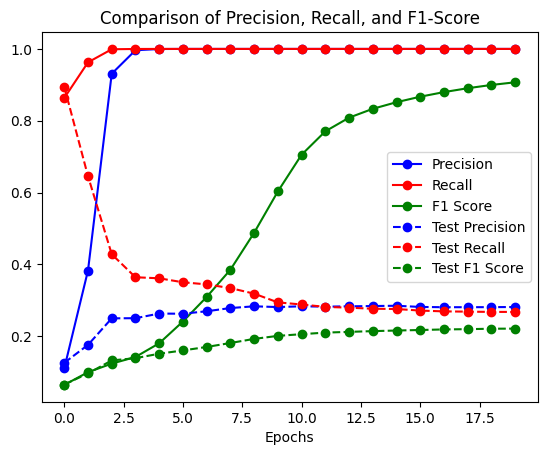

In [19]:
plt.plot(history.epoch, history.history['precision'], marker='o', color='blue', label='Precision', linestyle='solid')
plt.plot(history.epoch, history.history['recall'], marker='o', color='red', label='Recall', linestyle='solid')
plt.plot(history.epoch, history.history['f1_score'], marker='o', color='green', label='F1 Score', linestyle='solid')
plt.plot(history.epoch, history.history['val_precision'], marker='o', color='blue', label='Test Precision', linestyle='dashed')
plt.plot(history.epoch, history.history['val_recall'], marker='o', color='red', label='Test Recall', linestyle='dashed')
plt.plot(history.epoch, history.history['val_f1_score'], marker='o', color='green', label='Test F1 Score', linestyle='dashed')
plt.title('Comparison of Precision, Recall, and F1-Score')
plt.xlabel('Epochs')
plt.legend()
plt.show()

1258/1258 [==============================] - 9s 6ms/step
NCF Evaluation Metrics:
Precision: 0.2812
Recall: 0.2675
F1-Score: 0.2742


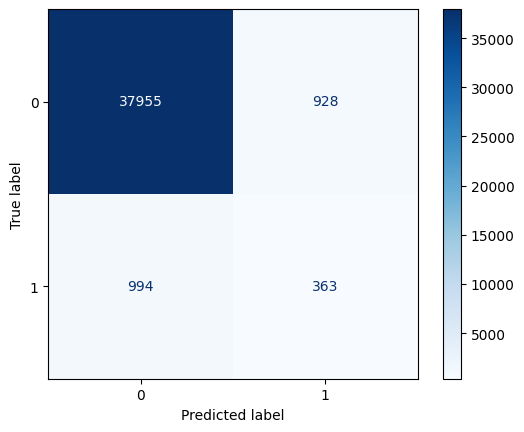

In [20]:
prediction = ncf_model.predict([test['User ID'],test['Updated Product ID']])
prediction = (prediction.flatten() >= 0.5).astype(int)
actual = test['Product Bought'].values.flatten()

ncf_precision = precision_score(actual, prediction)
ncf_recall = recall_score(actual, prediction)
ncf_f1 = f1_score(actual, prediction)
ncf_cm = confusion_matrix(actual, prediction)

print("NCF Evaluation Metrics:")
print(f"Precision: {ncf_precision:.4f}")
print(f"Recall: {ncf_recall:.4f}")
print(f"F1-Score: {ncf_f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=ncf_cm)
disp.plot(cmap='Blues')
plt.show()

In [21]:
def ncf_recommend(user_id, user_item_matrix, ncf_model, n_recommendations=3):
    if user_id not in user_item_matrix.index:
        raise ValueError(f"User {user_id} not found in the user-item matrix.")
        
    user_purchases = user_item_matrix.loc[user_id]
    product_ids = user_item_matrix.columns.tolist()
    user_array = np.full(len(product_ids), user_id)
    product_array = np.array(product_ids)
    predictions = ncf_model.predict([user_array, product_array], verbose=0)
    product_scores = pd.Series(predictions.flatten(), index=product_ids)
    
    # Remove already purchased products
    product_scores = product_scores * (user_purchases.values == 0)
    # Remove products with score = 0 (not purchased by any of the neighbors)
    product_scores = product_scores[product_scores > 0]
    
    recommended_indices = product_scores.sort_values(ascending=False)[:n_recommendations].index.tolist()

    # Add already purchased products
    if len(recommended_indices) < n_recommendations:
        purchased_products = user_purchases[user_purchases > 0].index.tolist()
        remaining_count = n_recommendations - len(recommended_indices)
        purchased_products = [p for p in purchased_products if p not in recommended_indices]
        recommended_indices.extend(purchased_products[:remaining_count])
    # Add top products (most purchased products from all users)
    if len(recommended_indices) < n_recommendations:
        remaining_count = n_recommendations - len(recommended_indices)
        top_products_filtered = [p for p in top_products if p not in recommended_indices]
        recommended_indices.extend(top_products_filtered[:remaining_count])
    
    recommended_products = [index_to_product[idx] for idx in recommended_indices]
    return recommended_products

In [22]:
#Check for a random user
user_id = user_item_matrix.sample(n=1).index[0]
recommended_products = ncf_recommend(user_id, user_item_matrix, ncf_model, 10)

print(f"Recommended products for {user_id}: {recommended_products}")

Recommended products for 2545: [20436, 2396, 610, 2386, 15535, 1707, 8041, 499, 8053, 8043]


In [23]:
metrics_data = {
    "Model": ["NCF", "SVD", "KNN"],
    "Precision": [ncf_precision, svd_precision, knn_precision],
    "Recall": [ncf_recall, svd_recall, knn_recall],
    "F1-Score": [ncf_f1, svd_f1, knn_f1],
}

metrics_data = pd.DataFrame(metrics_data)
metrics_data

,Model,Precision,Recall,F1-Score
0,NCF,0.281177,0.267502,0.274169
1,SVD,1.000000,0.966839,0.983140
2,KNN,0.885676,0.970523,0.926160


### Model Selection

We can see that **SVD** performs better on our training and testing data compared to other models. Hence, we will proceed with **SVD** for generating recommendations.

In [24]:
svd_production = TruncatedSVD(n_components=15)
svd_production.fit(user_item_matrix)
joblib.dump(svd_model, 'data/svd-model.pkl')

product_index = pd.DataFrame(index_to_product.items())
product_index.columns = ['Index', 'Product ID']
product_index.to_csv('data/product-index.csv', index=False)

### Conclusion

In this notebook, we explored multiple recommendation models, including **KNN**, **SVD**, and **NCF**, to build a collaborative filtering system. After evaluating the models using **MSE**, **RMSE**, and **MAE** metrics, we found that **SVD** outperformed others on both training and testing datasets. Based on these results, we have selected **SVD** as the final model for generating personalized recommendations due to its superior performance and consistency.

### Next Steps

Deploy the recommendation API in production and monitor its performance for continuous improvement

